In [99]:
%load_ext autoreload
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import ctypes
import time
import pysoem
import importlib
from helpers.EPOS4 import *
from helpers.position_camera_helpers import *
%aimport helpers.EPOS4
%aimport helpers.position_camera_helpers
%autoreload 1
import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Set up logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('EPOS4_repeatability_and_longevity_tests.log')
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to logger
logger.addHandler(fh)
logger.addHandler(ch)

# Setup and Home Each Slit

In [225]:
# Set up pysoem
if_offset = 4
ifname = pysoem.find_adapters()[if_offset].name
master = None
try:
    master = pysoem.Master(ifname)
    master.close()
    master.open(ifname)
    if master.config_init() > 0:
        logging.info("Found {} slaves".format(len(master.slaves)))
        for slave in master.slaves:
            slave.recover()
            logging.info("Found {} with Product ID {}".format(slave.name, slave.id))
    else:
        logging.error("No slaves found!")
        
except OSError as e:
    logging.error("Error while finding slaves: %s" % e)

2023-05-04 13:36:28,068 - root - INFO - Found 2 slaves
2023-05-04 13:36:28,069 - root - INFO - Found EPOS4 with Product ID 1766850560
2023-05-04 13:36:28,070 - root - INFO - Found EPOS4 with Product ID 1766850560


In [ ]:
# # Set up each slave
# for slave in master.slaves:
#     slave.recover()
#     logging.info("Configuring %s" % slave.name)
#     configure_slave(slave)

In [ ]:
# Home each slave
for slave in master.slaves:
    slave.recover()
    logging.info("Homing %s" % slave.name)
    home_slave(slave)

In [226]:
# Home each slave if the encoder has already been calibrated
for slave in master.slaves:
    logging.info("Homing %s" % slave.name)
    home_slave_using_current_ssi_position(slave)

2023-05-04 13:36:33,945 - root - INFO - Homing EPOS4
2023-05-04 13:36:36,077 - root - INFO - home_slave: homing successful with absolute position: 903
2023-05-04 13:36:36,078 - root - INFO - Homing EPOS4
2023-05-04 13:36:38,198 - root - INFO - home_slave: homing successful with absolute position: 6955


In [198]:
# Move each slave
move_value = -20000
for slave in master.slaves:
    clear_faults(slave)
    logging.info("Moving from {} to {}".format(get_position_actual_value(slave), get_position_actual_value(slave)+move_value))
    current_position = get_position_actual_value(slave)
    set_position_using_csp_mode(slave, current_position+move_value)

2023-05-04 12:42:34,455 - root - INFO - Moving from 1635 to -18365
2023-05-04 12:42:37,594 - root - INFO - Moving from 1611 to -18389


# Set up camera and take reference image

In [236]:
# Set up the camera
WEBCAM_INDEX = 1
camera = open_webcam(WEBCAM_INDEX)


: 

In [234]:
camera.release()

### Camera view of trackers

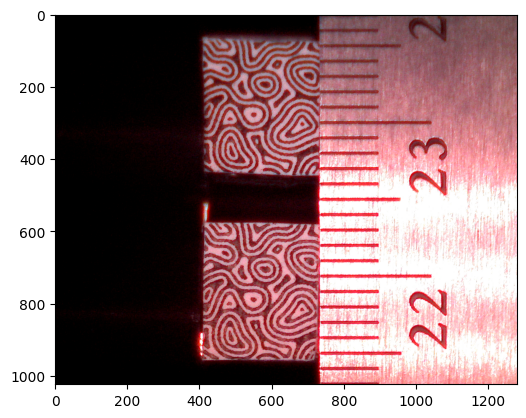

True

In [217]:
# get original tracker image for each slit
GAP_HEIGHT = 100
test_frame = get_frame(camera)
plt.imshow(test_frame)
plt.show()
cv2.imwrite("test_frame.png", test_frame)

### Pixels to um conversion

By taking a picture of a ruler in the same focal plane as the registration targets, we can compute the number of microns per pixel. The image shown below allows for pixels to be counted and results in a calibration value of approximately 23 microns per pixel.

<div>
<img src="calibration.png" width="500"/>
</div>

In [219]:
# convert pixels to um
UM_PER_PIXEL = 23

def p_to_um(p):
    return p*UM_PER_PIXEL

### Use camera to align the slits

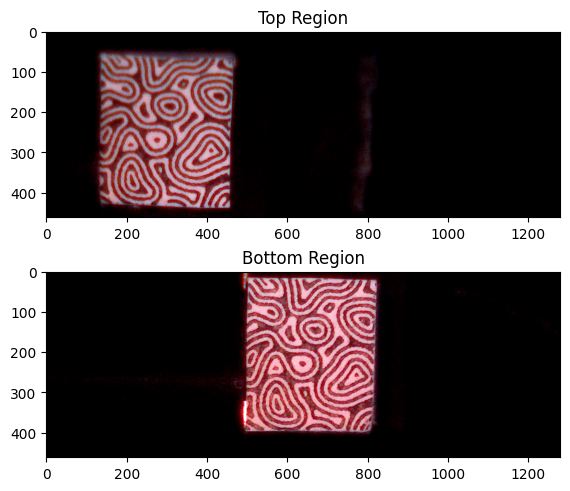

2023-05-04 13:36:50,898 - root - INFO - Offset (X, Y): (-361.0338316902119, 39.90079997226769)
2023-05-04 13:36:52,965 - root - INFO - Moving from 903 to 18954
2023-05-04 13:36:57,411 - root - INFO - Offset (X, Y): (-173.83711151327162, 45.34304260059281)
2023-05-04 13:36:59,459 - root - INFO - Moving from 18951 to 27642
2023-05-04 13:37:02,906 - root - INFO - Offset (X, Y): (-83.69385803824366, 49.27562853162948)
2023-05-04 13:37:04,962 - root - INFO - Moving from 27643 to 31827
2023-05-04 13:37:08,482 - root - INFO - Offset (X, Y): (-40.33482404760582, 49.740499428224894)
2023-05-04 13:37:10,535 - root - INFO - Moving from 31827 to 33843
2023-05-04 13:37:14,081 - root - INFO - Offset (X, Y): (-19.440850311686745, 49.661816270728195)
2023-05-04 13:37:16,132 - root - INFO - Moving from 33839 to 34811
2023-05-04 13:37:19,707 - root - INFO - Offset (X, Y): (-9.316944733105515, 49.552121161702075)
2023-05-04 13:37:21,762 - root - INFO - Moving from 34811 to 35276
2023-05-04 13:37:25,356 -

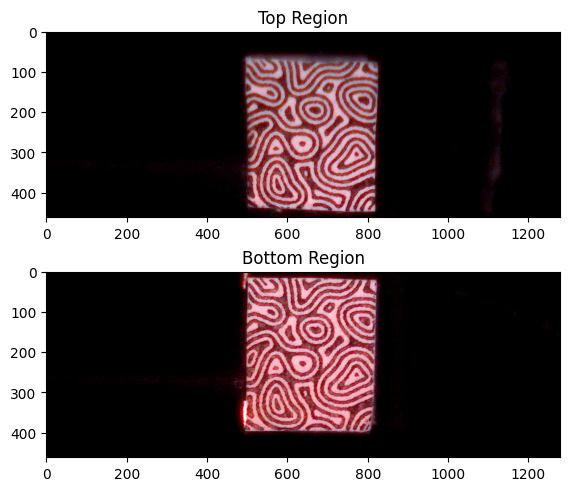

In [227]:
time.sleep(2)
OFFSET_LIMIT = 0.02

# get difference between top and bottom regions
initial_frame = get_frame(camera)
slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame, (initial_frame.shape[0]-GAP_HEIGHT)//2, True)
offset = get_pixel_shift_2d_fast(slit1_initial_image, slit2_initial_image)
logger.info("Offset (X, Y): {}".format(offset))

while (abs(offset[0]) > OFFSET_LIMIT):
    # Move each slave to try and align
    move_value = int(-50*offset[0])
    clear_faults(master.slaves[0])
    current_position = get_position_actual_value(master.slaves[0])
    logging.info("Moving from {} to {}".format(current_position, current_position+move_value))
    set_position_using_csp_mode(master.slaves[0], current_position+move_value)

    time.sleep(2)

    # get difference between top and bottom regions
    initial_frame = get_frame(camera)
    slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame, (initial_frame.shape[0]-GAP_HEIGHT)//2, False)
    offset = get_pixel_shift_2d_fast(slit1_initial_image, slit2_initial_image)
    logger.info("Offset (X, Y): {}".format(offset))

slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame, (initial_frame.shape[0]-GAP_HEIGHT)//2, True)


# Running a full test and sampling every time

In [21]:
# get original tracker image for each slit
UPSCALE_FACTOR = 5
initial_frame_upscaled = get_upscaled_frame(camera, UPSCALE_FACTOR)
slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame_upscaled, (initial_frame_upscaled.shape[0]-GAP_HEIGHT)//2, False)

# Move slaves apart and back together
slave0 = master.slaves[0]
slave1 = master.slaves[1]
MOVE_DISTANCE = -10000
SHIFT_DISTANCE = 0

slit1_offsets = []
slit2_offsets = []

for i in range(100):
    clear_faults(slave0)
    clear_faults(slave1)
    current_pos_slave0 = get_position_actual_value(slave0)
    current_pos_slave1 = get_position_actual_value(slave1)
    set_position_using_csp_mode(slave0, current_pos_slave0+MOVE_DISTANCE)
    set_position_using_csp_mode(slave1, current_pos_slave1-MOVE_DISTANCE)
    time.sleep(1)
    set_position_using_csp_mode(slave0, current_pos_slave0)
    set_position_using_csp_mode(slave1, current_pos_slave1-i*SHIFT_DISTANCE)
    time.sleep(3)
    differential_frame_upscaled = get_upscaled_frame(camera, UPSCALE_FACTOR)
    slit1_differential_image, slit2_differential_image = get_top_and_bottom_regions_color(differential_frame_upscaled, (differential_frame_upscaled.shape[0]-GAP_HEIGHT)//2, False)
    slit1_offsets.append(get_pixel_shift_2d(slit1_initial_image, slit1_differential_image, UPSCALE_FACTOR))
    slit2_offsets.append(get_pixel_shift_2d(slit2_initial_image, slit2_differential_image, UPSCALE_FACTOR))
    logger.info("Test #{}".format(i))
    logger.info("Slit 1 differential distance in pixels (X,Y): ({},{})".format(slit1_offsets[-1][0], slit1_offsets[-1][1]))
    logger.info("Slit 2 differential distance in pixels (X,Y): ({},{})".format(slit2_offsets[-1][0], slit2_offsets[-1][1]))
    

2023-05-02 14:27:44,747 - root - INFO - Test #0
2023-05-02 14:27:44,749 - root - INFO - Slit 1 differential distance in pixels (X,Y): (0.2,0.0)
2023-05-02 14:27:44,750 - root - INFO - Slit 2 differential distance in pixels (X,Y): (0.0,0.0)
2023-05-02 14:28:11,839 - root - INFO - Test #1
2023-05-02 14:28:11,841 - root - INFO - Slit 1 differential distance in pixels (X,Y): (0.0,0.8)
2023-05-02 14:28:11,842 - root - INFO - Slit 2 differential distance in pixels (X,Y): (0.0,-0.2)
2023-05-02 14:28:38,847 - root - INFO - Test #2
2023-05-02 14:28:38,848 - root - INFO - Slit 1 differential distance in pixels (X,Y): (0.0,0.2)
2023-05-02 14:28:38,849 - root - INFO - Slit 2 differential distance in pixels (X,Y): (0.0,0.0)
2023-05-02 14:29:05,815 - root - INFO - Test #3
2023-05-02 14:29:05,817 - root - INFO - Slit 1 differential distance in pixels (X,Y): (0.0,0.2)
2023-05-02 14:29:05,818 - root - INFO - Slit 2 differential distance in pixels (X,Y): (0.0,0.0)
2023-05-02 14:29:32,782 - root - INFO -

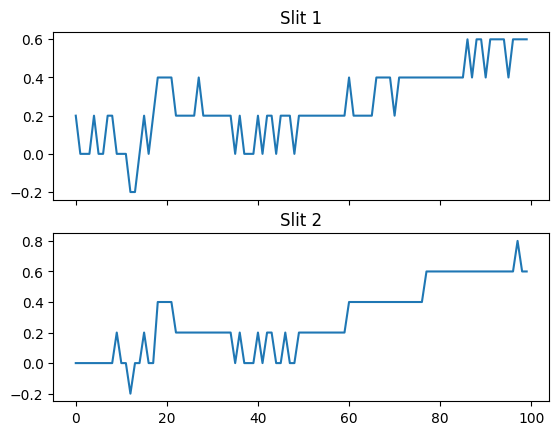

In [22]:

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot([x[0] for x in slit1_offsets])
axarr[0].set_title('Slit 1')
axarr[1].plot([x[0] for x in slit2_offsets])
axarr[1].set_title('Slit 2')
plt.show()

# Full test but with faster implementation of subpixel analysis

In [228]:
# get original tracker image for each slit
UPSCALE_FACTOR = 1
initial_frame = get_frame(camera)
slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame, (initial_frame.shape[0]-GAP_HEIGHT)//2, False)

# Move slaves apart and back together
slave0 = master.slaves[0]
slave1 = master.slaves[1]
MOVE_DISTANCE = -10000

slit1_offsets_long_fast = []
slit2_offsets_long_fast = []
slits_differential_offset_long_fast = []

clear_faults(slave0)
clear_faults(slave1)
current_pos_slave0 = get_position_actual_value(slave0)
current_pos_slave1 = get_position_actual_value(slave1)

set_position_using_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
set_position_using_csp_mode(slave1, current_pos_slave1, ignore_errors=True)
time.sleep(1)

for i in range(200):
    differential_frame = get_frame(camera)
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0+MOVE_DISTANCE, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1-MOVE_DISTANCE, ignore_errors=True)
    time.sleep(0.5)
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1, ignore_errors=True)
    time.sleep(2)
    slit1_differential_image, slit2_differential_image = get_top_and_bottom_regions_color(differential_frame, (differential_frame.shape[0]-GAP_HEIGHT)//2, False)
    slit1_offsets_long_fast.append(get_pixel_shift_2d_fast(slit1_initial_image, slit1_differential_image, display=False))
    slit2_offsets_long_fast.append(get_pixel_shift_2d_fast(slit2_initial_image, slit2_differential_image,  display=False))
    slits_differential_offset_long_fast.append(get_pixel_shift_2d_fast(slit1_differential_image, slit2_differential_image,  display=False))
    logger.info("Test #{}".format(i))
    logger.info("Slit 1 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit1_offsets_long_fast[-1][0], slit1_offsets_long_fast[-1][1]))
    logger.info("Slit 2 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit2_offsets_long_fast[-1][0], slit2_offsets_long_fast[-1][1]))
    logger.info("Slits differential distance in pixels (X,Y): ({:.3f},{:.3f})".format(slits_differential_offset_long_fast[-1][0], slits_differential_offset_long_fast[-1][1]))


2023-05-04 13:39:08,465 - root - INFO - Test #0
2023-05-04 13:39:08,466 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.018,0.024)
2023-05-04 13:39:08,467 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.023,0.022)
2023-05-04 13:39:08,468 - root - INFO - Slits differential distance in pixels (X,Y): (0.059,49.479)
2023-05-04 13:39:16,211 - root - INFO - Test #1
2023-05-04 13:39:16,212 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.020,0.156)
2023-05-04 13:39:16,212 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.131,-0.005)
2023-05-04 13:39:16,213 - root - INFO - Slits differential distance in pixels (X,Y): (-0.084,49.333)
2023-05-04 13:39:23,945 - root - INFO - Test #2
2023-05-04 13:39:23,947 - root - INFO - Slit 1 drift distance in pixels (X,Y): (0.029,0.168)
2023-05-04 13:39:23,947 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.101,-0.003)
2023-05-04 13:39:23,948 - root - INFO - Slits differential distance in pixels (X,Y): (-0.0

KeyboardInterrupt: 

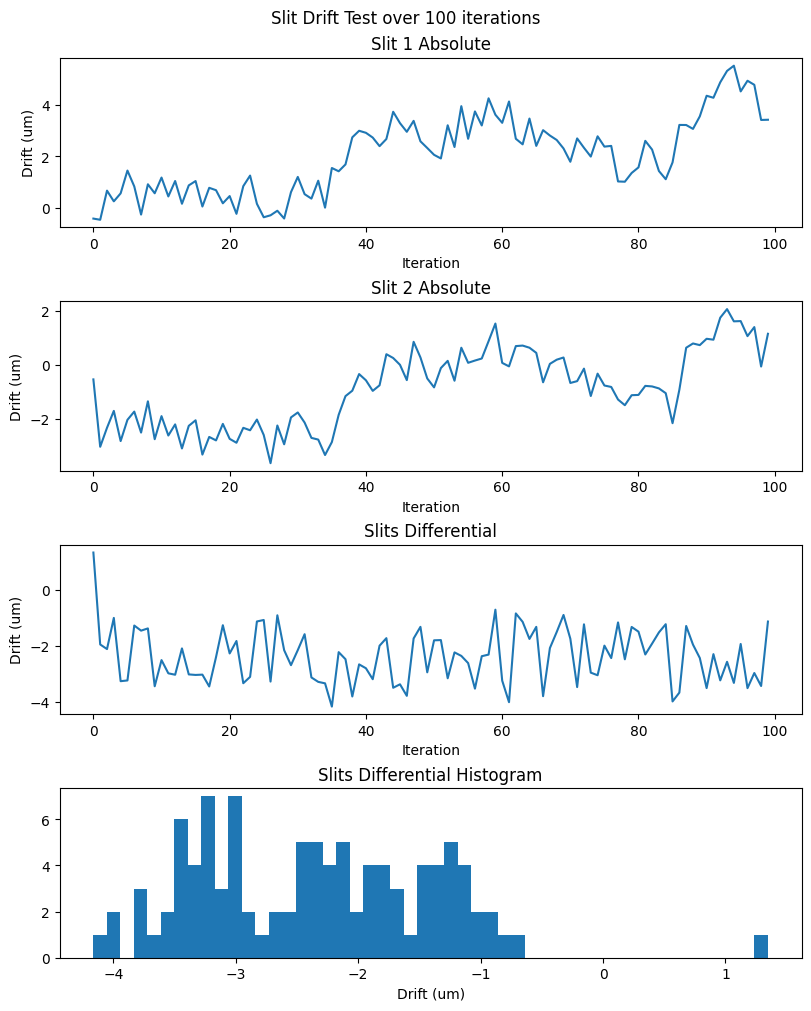

In [233]:
f, axarr = plt.subplots(4, sharex=False, constrained_layout=True, figsize=(8,10))
axarr[0].plot([p_to_um(x[0]) for x in slit1_offsets_long_fast[:100]])
axarr[0].set_title('Slit 1 Absolute')
axarr[0].set_ylabel('Drift (um)')
axarr[0].set_xlabel('Iteration')
axarr[1].plot([p_to_um(x[0]) for x in slit2_offsets_long_fast[:100]])
axarr[1].set_title('Slit 2 Absolute')
axarr[1].set_ylabel('Drift (um)')
axarr[1].set_xlabel('Iteration')
axarr[2].plot([p_to_um(x[0]) for x in slits_differential_offset_long_fast[:100]])
axarr[2].set_title('Slits Differential')
axarr[2].set_ylabel('Drift (um)')
axarr[2].set_xlabel('Iteration')
axarr[3].hist([p_to_um(x[0]) for x in slits_differential_offset_long_fast[:100]], bins=50)
axarr[3].set_title('Slits Differential Histogram')
axarr[3].set_xlabel('Drift (um)')
f.suptitle('Slit Drift Test over 100 iterations')
plt.show()

### Test with known offset stepping to determine linearity

In [151]:
# get original tracker image for each slit
OFFSET_STEP = 10
initial_frame = get_frame(camera)
slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame, (initial_frame.shape[0]-GAP_HEIGHT)//2, False)

# Move slaves apart and back together
slave0 = master.slaves[0]
slave1 = master.slaves[1]
MOVE_DISTANCE = -10000

slit1_offsets_linearity = []
slit2_offsets_linearity = []
slits_differential_offset_linearity = []

clear_faults(slave0)
clear_faults(slave1)
current_pos_slave0 = get_position_actual_value(slave0)
current_pos_slave1 = get_position_actual_value(slave1)

set_position_using_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
set_position_using_csp_mode(slave1, current_pos_slave1, ignore_errors=True)
time.sleep(1)

for i in range(100):
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0+MOVE_DISTANCE, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1-MOVE_DISTANCE, ignore_errors=True)
    time.sleep(0.5)
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1+OFFSET_STEP*i, ignore_errors=True)
    time.sleep(0.5)
    time.sleep(3)
    differential_frame = get_frame(camera)
    slit1_differential_image, slit2_differential_image = get_top_and_bottom_regions_color(differential_frame, (differential_frame.shape[0]-GAP_HEIGHT)//2, False)
    slit1_offsets_linearity.append(get_pixel_shift_2d_fast(slit1_initial_image, slit1_differential_image, display=False))
    slit2_offsets_linearity.append(get_pixel_shift_2d_fast(slit2_initial_image, slit2_differential_image,  display=False))
    slits_differential_offset_linearity.append(get_pixel_shift_2d_fast(slit1_differential_image, slit2_differential_image,  display=False))
    logger.info("Test #{}".format(i))
    logger.info("Slit 1 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit1_offsets_linearity[-1][0], slit1_offsets_linearity[-1][1]))
    logger.info("Slit 2 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit2_offsets_linearity[-1][0], slit2_offsets_linearity[-1][1]))
    logger.info("Slits differential distance in pixels (X,Y): ({:.3f},{:.3f})".format(slits_differential_offset_linearity[-1][0], slits_differential_offset_linearity[-1][1]))

# Reset positions back to starting place
time.sleep(0.5)
fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
fast_position_move_already_in_csp_mode(slave1, current_pos_slave1, ignore_errors=True)

2023-05-03 15:57:08,497 - root - INFO - Test #0
2023-05-03 15:57:08,498 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.015,0.055)
2023-05-03 15:57:08,499 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.095,-0.031)
2023-05-03 15:57:08,500 - root - INFO - Slits differential distance in pixels (X,Y): (-0.132,49.823)
2023-05-03 15:57:17,648 - root - INFO - Test #1
2023-05-03 15:57:17,649 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.048,0.112)
2023-05-03 15:57:17,650 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.229,-0.011)
2023-05-03 15:57:17,651 - root - INFO - Slits differential distance in pixels (X,Y): (-0.241,49.785)
2023-05-03 15:57:26,929 - root - INFO - Test #2
2023-05-03 15:57:26,930 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.040,0.082)
2023-05-03 15:57:26,931 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.296,-0.064)
2023-05-03 15:57:26,931 - root - INFO - Slits differential distance in pixels (X,Y): (-

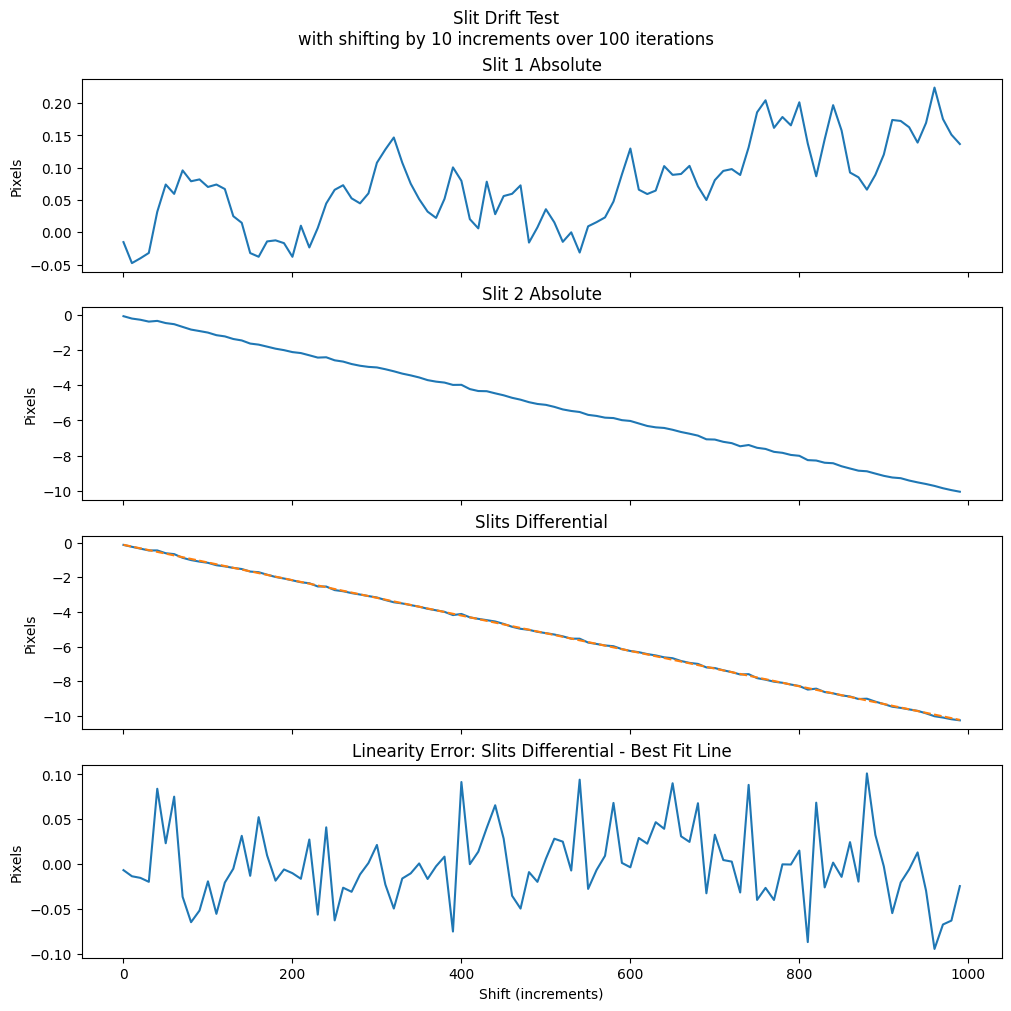

In [174]:
OFFSET_STEP = 10
x = range(0, 1000, OFFSET_STEP)
best_fit_line = np.poly1d(np.polyfit(x, [x[0] for x in slits_differential_offset_linearity], 1))(x)
f, axarr = plt.subplots(4, sharex=True, constrained_layout=True, figsize=(10,10))
axarr[0].plot(x, [x[0] for x in slit1_offsets_linearity])
axarr[0].set_title('Slit 1 Absolute')
axarr[0].set_ylabel('Pixels')
axarr[1].plot(x, [x[0] for x in slit2_offsets_linearity])
axarr[1].set_title('Slit 2 Absolute')
axarr[1].set_ylabel('Pixels')
axarr[2].plot(x, [x[0] for x in slits_differential_offset_linearity])
axarr[2].plot(x, best_fit_line, '--')
axarr[2].set_title('Slits Differential')
axarr[2].set_ylabel('Pixels')
axarr[3].plot(x, [x[0]-best_fit_line[i] for i, x in enumerate(slits_differential_offset_linearity)])
axarr[3].set_title('Linearity Error: Slits Differential - Best Fit Line')
axarr[3].set_xlabel('Shift (increments)')
axarr[3].set_ylabel('Pixels')
f.suptitle('Slit Drift Test\nwith shifting by {} increments over 100 iterations'.format(OFFSET_STEP))
plt.show()

### Calculate camera measurement repeatability with stationary bars

In [160]:
time.sleep(5)
initial_frame = get_frame(camera)
slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame, (initial_frame.shape[0]-GAP_HEIGHT)//2, False)

slit1_camera_offsets = []
slit2_camera_offsets = []
slits_camera_differential_offsets = []

for i in range(100):
    # time.sleep(1)
    differential_frame = get_frame(camera)
    slit1_differential_image, slit2_differential_image = get_top_and_bottom_regions_color(differential_frame, (differential_frame.shape[0]-GAP_HEIGHT)//2, False)
    slit1_camera_offsets.append(get_pixel_shift_2d_fast(slit1_initial_image, slit1_differential_image, display=False))
    slit2_camera_offsets.append(get_pixel_shift_2d_fast(slit2_initial_image, slit2_differential_image,  display=False))
    slits_camera_differential_offsets.append(get_pixel_shift_2d_fast(slit1_differential_image, slit2_differential_image,  display=False))
    logger.info("Test #{}: Slit 1 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(i, slit1_camera_offsets[-1][0], slit1_camera_offsets[-1][1]))
    # logger.info("Slit 2 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit2_camera_offsets[-1][0], slit2_camera_offsets[-1][1]))
    # logger.info("Slits differential distance in pixels (X,Y): ({:.3f},{:.3f})".format(slits_camera_differential_offsets[-1][0], slits_camera_differential_offsets[-1][1]))

2023-05-04 09:41:07,648 - root - INFO - Test #0: Slit 1 drift distance in pixels (X,Y): (-0.000,0.004)
2023-05-04 09:41:08,487 - root - INFO - Test #1: Slit 1 drift distance in pixels (X,Y): (-0.000,0.025)
2023-05-04 09:41:09,262 - root - INFO - Test #2: Slit 1 drift distance in pixels (X,Y): (0.007,0.019)
2023-05-04 09:41:10,069 - root - INFO - Test #3: Slit 1 drift distance in pixels (X,Y): (0.004,0.020)
2023-05-04 09:41:10,881 - root - INFO - Test #4: Slit 1 drift distance in pixels (X,Y): (0.014,0.021)
2023-05-04 09:41:11,685 - root - INFO - Test #5: Slit 1 drift distance in pixels (X,Y): (0.013,0.020)
2023-05-04 09:41:12,525 - root - INFO - Test #6: Slit 1 drift distance in pixels (X,Y): (0.018,0.017)
2023-05-04 09:41:13,416 - root - INFO - Test #7: Slit 1 drift distance in pixels (X,Y): (0.021,0.008)
2023-05-04 09:41:14,324 - root - INFO - Test #8: Slit 1 drift distance in pixels (X,Y): (0.023,0.001)
2023-05-04 09:41:15,247 - root - INFO - Test #9: Slit 1 drift distance in pixels

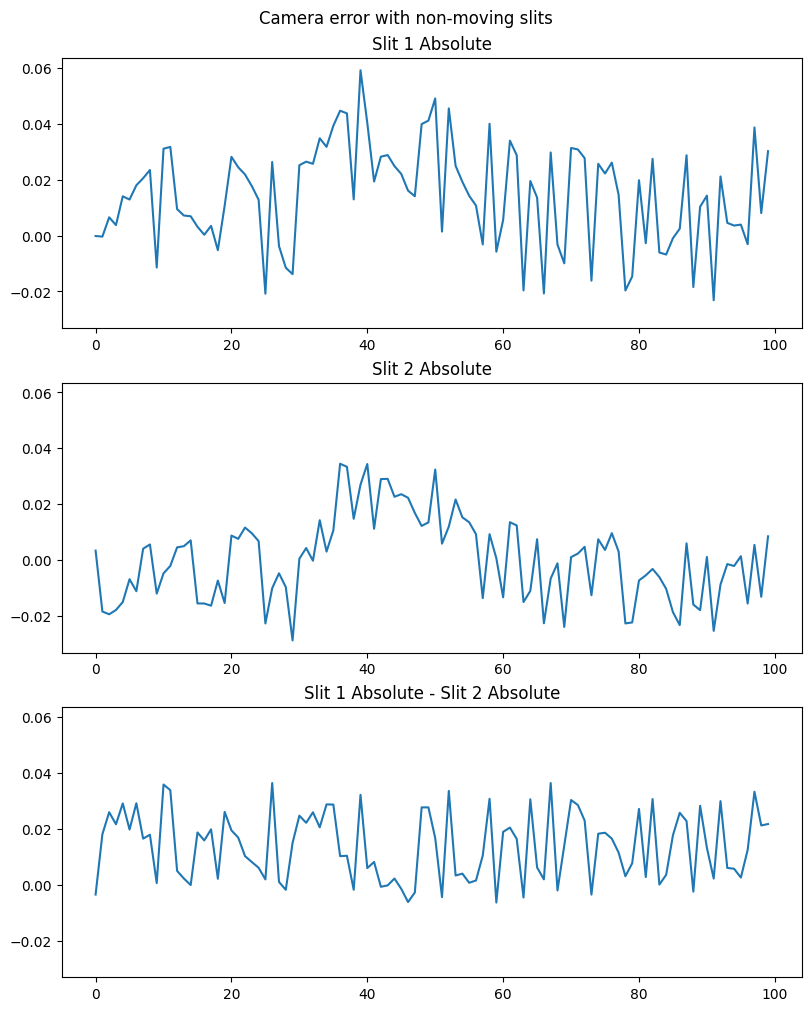

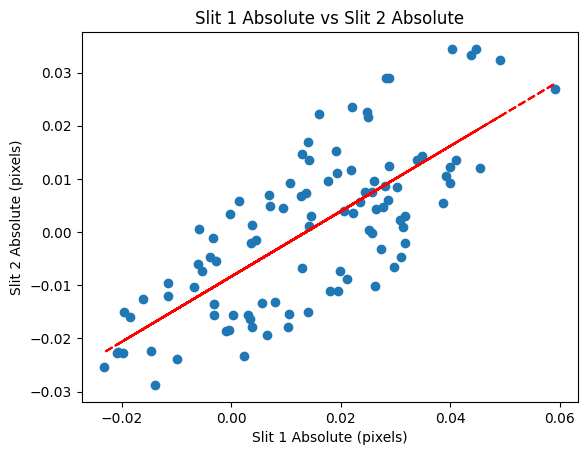

In [214]:
f, axarr = plt.subplots(3, sharex=False, sharey=True, constrained_layout=True, figsize=(8,10))
axarr[0].plot([x[0] for x in slit1_camera_offsets])
axarr[0].set_title('Slit 1 Absolute')
axarr[1].plot([x[0] for x in slit2_camera_offsets])
axarr[1].set_title('Slit 2 Absolute')
axarr[2].plot([x[0]-y[0] for x, y in zip(slit1_camera_offsets, slit2_camera_offsets)])
axarr[2].set_title('Slit 1 Absolute - Slit 2 Absolute')
f.suptitle('Camera error with non-moving slits')
plt.show()

best_fit_line = np.poly1d(np.polyfit([x[0] for x in slit1_camera_offsets], [x[0] for x in slit2_camera_offsets], 1))([x[0] for x in slit1_camera_offsets])
plt.scatter([x[0] for x in slit1_camera_offsets], [x[0] for x in slit2_camera_offsets])
plt.plot([x[0] for x in slit1_camera_offsets], best_fit_line, '--', color='red')
plt.title('Slit 1 Absolute vs Slit 2 Absolute')
plt.xlabel('Slit 1 Absolute (pixels)')
plt.ylabel('Slit 2 Absolute (pixels)')
plt.show()

### Do single incremenent stepping

### do twice and see if can calculate encoder errors

In [167]:
# get original tracker image for each slit
OFFSET_STEP = 1
initial_frame = get_frame(camera)
slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame, (initial_frame.shape[0]-GAP_HEIGHT)//2, False)

# Move slaves apart and back together
slave0 = master.slaves[0]
slave1 = master.slaves[1]
MOVE_DISTANCE = -10000

slit1_offsets_microstep = []
slit2_offsets_microstep = []
slits_differential_offset_microstep = []

clear_faults(slave0)
clear_faults(slave1)
current_pos_slave0 = get_position_actual_value(slave0)
current_pos_slave1 = get_position_actual_value(slave1)

set_position_using_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
set_position_using_csp_mode(slave1, current_pos_slave1, ignore_errors=True)
time.sleep(1)

for i in range(500):
    differential_frame = get_frame(camera)
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0+MOVE_DISTANCE, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1-MOVE_DISTANCE, ignore_errors=True)
    time.sleep(0.5)
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1+OFFSET_STEP*i, ignore_errors=True)
    time.sleep(2)    
    slit1_differential_image, slit2_differential_image = get_top_and_bottom_regions_color(differential_frame, (differential_frame.shape[0]-GAP_HEIGHT)//2, False)
    slit1_offsets_microstep.append(get_pixel_shift_2d_fast(slit1_initial_image, slit1_differential_image, display=False))
    slit2_offsets_microstep.append(get_pixel_shift_2d_fast(slit2_initial_image, slit2_differential_image,  display=False))
    slits_differential_offset_microstep.append(get_pixel_shift_2d_fast(slit1_differential_image, slit2_differential_image,  display=False))
    logger.info("Test #{}".format(i))
    logger.info("Slit 1 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit1_offsets_microstep[-1][0], slit1_offsets_microstep[-1][1]))
    logger.info("Slit 2 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit2_offsets_microstep[-1][0], slit2_offsets_microstep[-1][1]))
    logger.info("Slits differential distance in pixels (X,Y): ({:.3f},{:.3f})".format(slits_differential_offset_microstep[-1][0], slits_differential_offset_microstep[-1][1]))

# Reset positions back to starting place
time.sleep(0.5)
fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
fast_position_move_already_in_csp_mode(slave1, current_pos_slave1, ignore_errors=True)

2023-05-04 09:52:10,998 - root - INFO - Test #0
2023-05-04 09:52:10,999 - root - INFO - Slit 1 drift distance in pixels (X,Y): (0.012,0.009)
2023-05-04 09:52:11,000 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.003,-0.024)
2023-05-04 09:52:11,001 - root - INFO - Slits differential distance in pixels (X,Y): (-0.004,50.274)
2023-05-04 09:52:19,670 - root - INFO - Test #1
2023-05-04 09:52:19,671 - root - INFO - Slit 1 drift distance in pixels (X,Y): (0.033,0.009)
2023-05-04 09:52:19,672 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.046,-0.060)
2023-05-04 09:52:19,673 - root - INFO - Slits differential distance in pixels (X,Y): (-0.062,50.234)
2023-05-04 09:52:27,353 - root - INFO - Test #2
2023-05-04 09:52:27,354 - root - INFO - Slit 1 drift distance in pixels (X,Y): (0.046,-0.006)
2023-05-04 09:52:27,355 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.080,-0.040)
2023-05-04 09:52:27,356 - root - INFO - Slits differential distance in pixels (X,Y): (-0.

KeyboardInterrupt: 

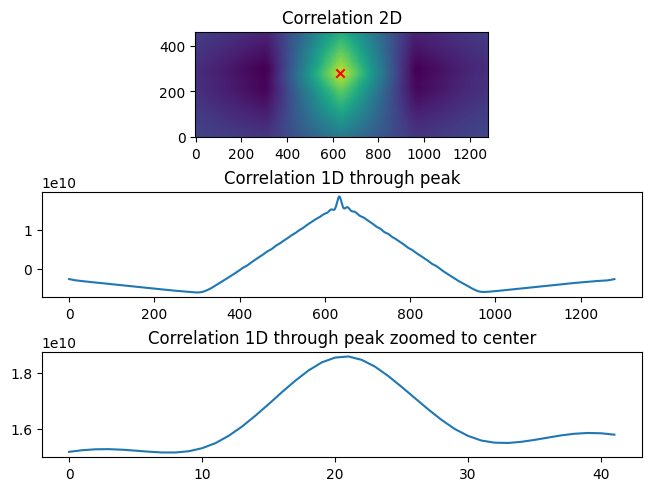

2023-05-03 15:53:44,933 - root - INFO - Test #0
2023-05-03 15:53:44,934 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.068,0.043)
2023-05-03 15:53:44,935 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.159,-0.032)
2023-05-03 15:53:44,936 - root - INFO - Slits differential distance in pixels (X,Y): (-6.067,50.084)


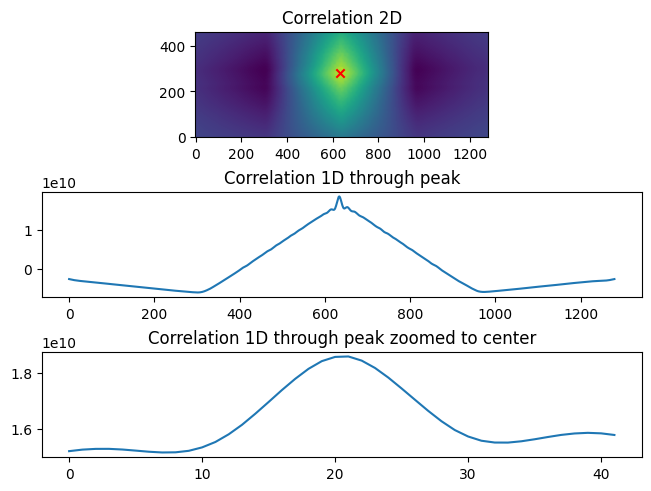

2023-05-03 15:53:55,779 - root - INFO - Test #1
2023-05-03 15:53:55,779 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.048,0.048)
2023-05-03 15:53:55,780 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.314,-0.010)
2023-05-03 15:53:55,780 - root - INFO - Slits differential distance in pixels (X,Y): (-6.233,50.085)


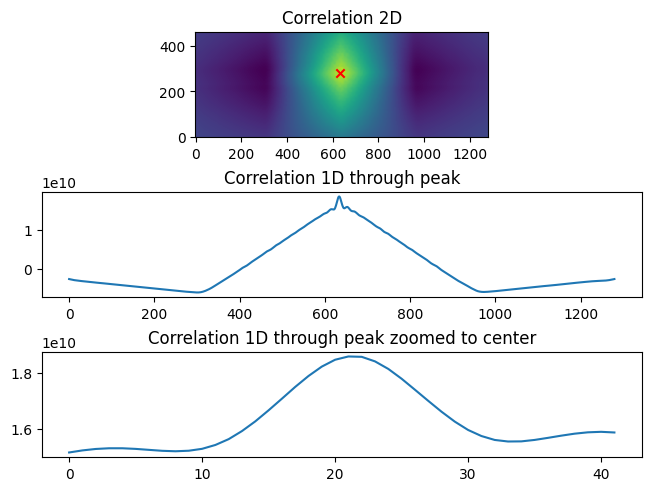

2023-05-03 15:54:06,544 - root - INFO - Test #2
2023-05-03 15:54:06,545 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.010,0.028)
2023-05-03 15:54:06,545 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.447,-0.063)
2023-05-03 15:54:06,546 - root - INFO - Slits differential distance in pixels (X,Y): (-6.405,50.055)


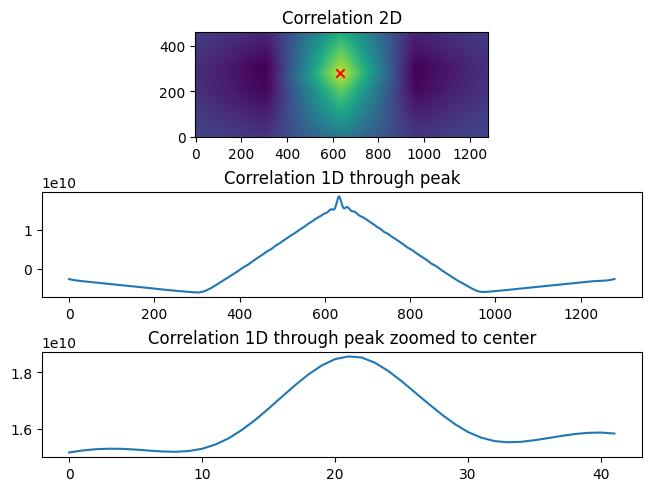

2023-05-03 15:54:16,390 - root - INFO - Test #3
2023-05-03 15:54:16,391 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.010,-0.010)
2023-05-03 15:54:16,392 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.665,-0.067)
2023-05-03 15:54:16,393 - root - INFO - Slits differential distance in pixels (X,Y): (-6.607,50.077)


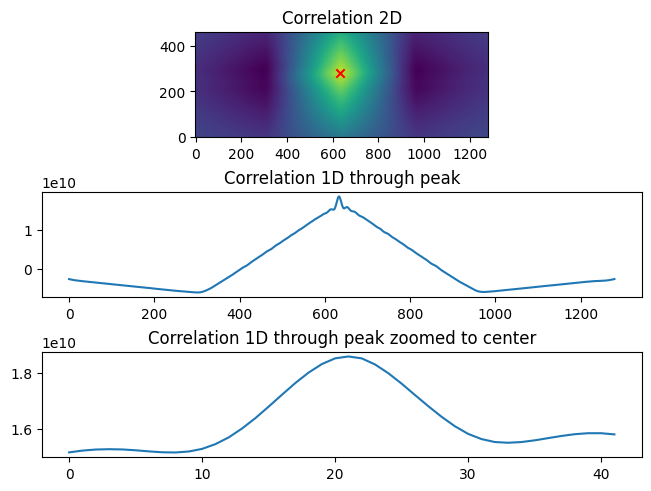

2023-05-03 15:54:26,194 - root - INFO - Test #4
2023-05-03 15:54:26,195 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.037,0.016)
2023-05-03 15:54:26,196 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-0.901,-0.029)
2023-05-03 15:54:26,197 - root - INFO - Slits differential distance in pixels (X,Y): (-6.809,50.087)


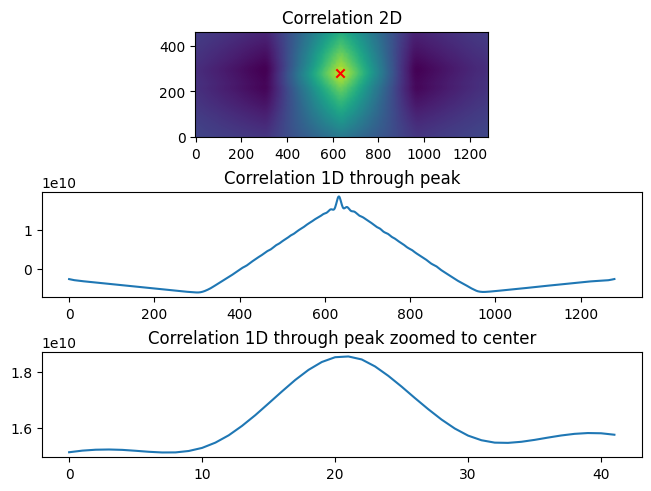

2023-05-03 15:54:36,962 - root - INFO - Test #5
2023-05-03 15:54:36,962 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.039,-0.011)
2023-05-03 15:54:36,963 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-1.152,-0.068)
2023-05-03 15:54:36,963 - root - INFO - Slits differential distance in pixels (X,Y): (-7.085,50.086)


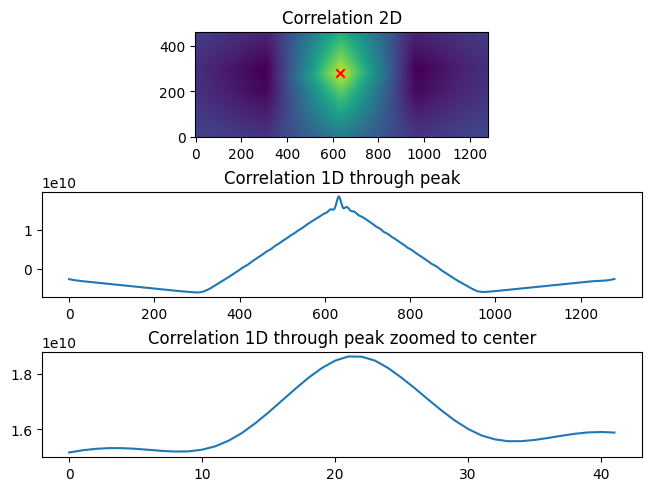

2023-05-03 15:54:47,782 - root - INFO - Test #6
2023-05-03 15:54:47,783 - root - INFO - Slit 1 drift distance in pixels (X,Y): (0.012,-0.020)
2023-05-03 15:54:47,784 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-1.288,-0.069)
2023-05-03 15:54:47,785 - root - INFO - Slits differential distance in pixels (X,Y): (-7.265,50.085)


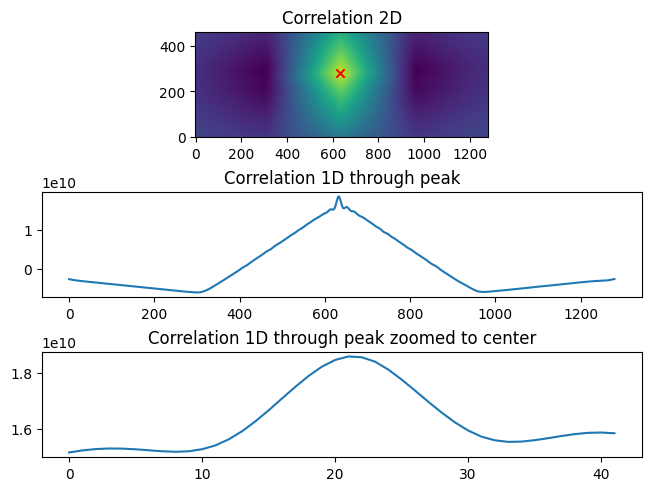

2023-05-03 15:54:58,563 - root - INFO - Test #7
2023-05-03 15:54:58,564 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.027,-0.022)
2023-05-03 15:54:58,565 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-1.528,-0.038)
2023-05-03 15:54:58,565 - root - INFO - Slits differential distance in pixels (X,Y): (-7.446,50.113)


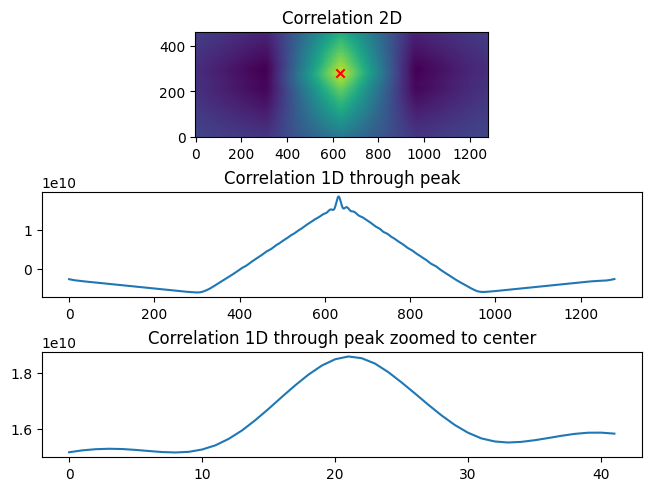

2023-05-03 15:55:08,466 - root - INFO - Test #8
2023-05-03 15:55:08,471 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.090,0.016)
2023-05-03 15:55:08,474 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-1.775,-0.005)
2023-05-03 15:55:08,475 - root - INFO - Slits differential distance in pixels (X,Y): (-7.652,50.122)


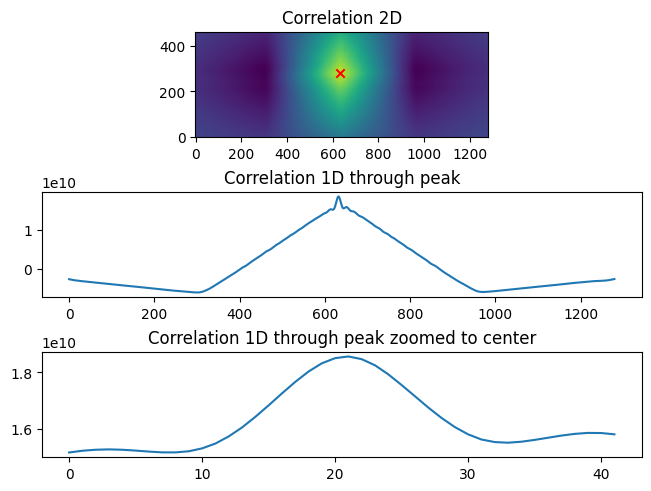

2023-05-03 15:55:18,599 - root - INFO - Test #9
2023-05-03 15:55:18,600 - root - INFO - Slit 1 drift distance in pixels (X,Y): (-0.068,-0.026)
2023-05-03 15:55:18,600 - root - INFO - Slit 2 drift distance in pixels (X,Y): (-2.013,-0.052)
2023-05-03 15:55:18,601 - root - INFO - Slits differential distance in pixels (X,Y): (-7.925,50.124)


KeyboardInterrupt: 

In [148]:
# get original tracker image for each slit
OFFSET_STEP = 20
PEAK_WIDTH = 21
initial_frame = get_frame(camera)
slit1_initial_image, slit2_initial_image = get_top_and_bottom_regions_color(initial_frame, (initial_frame.shape[0]-GAP_HEIGHT)//2, False)

# Move slaves apart and back together
slave0 = master.slaves[0]
slave1 = master.slaves[1]
MOVE_DISTANCE = -10000

slit1_offsets_linearity = []
slit2_offsets_linearity = []
slits_differential_offset_linearity = []

clear_faults(slave0)
clear_faults(slave1)
current_pos_slave0 = get_position_actual_value(slave0)
current_pos_slave1 = get_position_actual_value(slave1)

set_position_using_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
set_position_using_csp_mode(slave1, current_pos_slave1, ignore_errors=True)
time.sleep(1)

for i in range(50):
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0+MOVE_DISTANCE, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1-MOVE_DISTANCE, ignore_errors=True)
    time.sleep(0.5)
    fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
    fast_position_move_already_in_csp_mode(slave1, current_pos_slave1+OFFSET_STEP*i, ignore_errors=True)
    time.sleep(0.5)
    time.sleep(3)
    differential_frame = get_frame(camera)
    slit1_differential_image, slit2_differential_image = get_top_and_bottom_regions_color(differential_frame, (differential_frame.shape[0]-GAP_HEIGHT)//2, False)
    slit1_offsets_linearity.append(get_pixel_shift_2d_fast(slit1_initial_image, slit1_differential_image, peak_width=PEAK_WIDTH, display=False))
    slit2_offsets_linearity.append(get_pixel_shift_2d_fast(slit2_initial_image, slit2_differential_image, peak_width=PEAK_WIDTH, display=False))
    slits_differential_offset_linearity.append(get_pixel_shift_2d_fast(slit1_differential_image, slit2_differential_image, peak_width=PEAK_WIDTH, display=True))
    logger.info("Test #{}".format(i))
    logger.info("Slit 1 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit1_offsets_linearity[-1][0], slit1_offsets_linearity[-1][1]))
    logger.info("Slit 2 drift distance in pixels (X,Y): ({:.3f},{:.3f})".format(slit2_offsets_linearity[-1][0], slit2_offsets_linearity[-1][1]))
    logger.info("Slits differential distance in pixels (X,Y): ({:.3f},{:.3f})".format(slits_differential_offset_linearity[-1][0], slits_differential_offset_linearity[-1][1]))

# Reset positions back to starting place
time.sleep(0.5)
fast_position_move_already_in_csp_mode(slave0, current_pos_slave0, ignore_errors=True)
fast_position_move_already_in_csp_mode(slave1, current_pos_slave1, ignore_errors=True)